# A/B Testing - PA Bond

## 0.1 Imports

In [135]:
import pandas as pd
import math
from statsmodels.stats import api as sms
import numpy as np
import seaborn as sns
from scipy.stats import ttest_1samp, shapiro, ttest_ind, mannwhitneyu, f_oneway, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
from matplotlib import pyplot as plt
from scipy import stats


# 1.0 Load data

In [5]:
df_raw = pd.read_csv('../PA_bond/ab_testing.csv')

In [6]:
df_raw.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


# 2.0 Design de Experimentos

In [ ]:
#Objetivo: Definir se o preenchimento automativo da pagina checkout é melhor do que o prenchimento manual.
#Métrica: GMV(Gross Margin Reneveu) médio


#A = Preenchimento automático
#B = Preenhimento manual

#I = Compra feita através do site
#A= Compra feita através do App

#Metricas com uma dispersão naturalmente menor
#Conversão - (0 - 1)
#Compras - (0 - Unidades)
#GMV - (0 - R$: 30.000)

## 2.1 Formulação da Hipóteses

In [27]:
#H0: avg GMV A = avg GMV B
#H1: avg GMV A <> avg GMV B

## 2.2 Denifir o tamanho da amostra

In [118]:

#init_metric = metric atual (media do GMV, media Sales)
#end_metric = metric lift (5% sobre a metrica atual )
#pg.compute_effsize(x,y, eftype='cohen')

# tamanho do efeito

init_metric = 1902.86
end_metric = init_metric * (1 + 0.05)
std_metric = 1398.89

effect_size = (end_metric - init_metric)/std_metric


sample_size = sms.tt_ind_solve_power(
    effect_size=effect_size,
    alpha=0.05,
    power=0.80
)

sample_size = np.ceil(sample_size).astype(int)
print(sample_size)

3395


# 3.0 Analises descritivas dos dados

In [104]:
print('Number of rows: {}'.format(df_raw.shape[0]))
print('Number of cols: {}'.format(df_raw.shape[1]))

Number of rows: 45883
Number of cols: 8


In [105]:
df_raw.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

In [106]:
df_raw.dtypes

uid                  object
country              object
gender               object
spent                 int64
purchases             int64
date         datetime64[ns]
group                object
device               object
dtype: object

In [107]:
df_raw['date']= pd.to_datetime (df_raw['date'])
df_raw['uid'] = df_raw['uid'].astype(str)

In [108]:
df_raw[['uid','group']].groupby('group').count().reset_index()

,group,uid
0,GRP A,23009
1,GRP B,22874


## 3.1 Escola de um país (BRASIL)

In [159]:
df1 = df_raw.loc [df_raw['country'] =='BRA', :]
df1.head()

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A
31,11172970,BRA,M,1797,3,2017-07-05,GRP B,I
36,11177332,BRA,M,1994,6,2017-01-06,GRP B,I
37,11179295,BRA,M,1198,2,2017-12-19,GRP B,A


In [160]:
df1['spent'].agg(['mean', 'std'])

mean    1902.860251
std     1398.886279
Name: spent, dtype: float64

In [162]:
print('Number of Rows:{}'.format(df1.shape[0]))
print('Number of Cols:{}'.format(df1.shape[1]))

Number of Rows:9009
Number of Cols:8


In [112]:
df1[['uid','group']].groupby('group').count().reset_index()
df1[['uid','group']].groupby('uid').count().reset_index().query('group>1')

,uid,group


### 3.1.1 Control and Treatment Homogenity

In [113]:
df1[['uid','group','gender']].groupby(['group', 'gender']).count().reset_index()

,group,gender,uid
0,GRP A,F,2213
1,GRP A,M,2305
2,GRP B,F,2208
3,GRP B,M,2283


In [114]:
df1[['uid','group','device']].groupby(['group', 'device']).count().reset_index()

,group,device,uid
0,GRP A,A,2208
1,GRP A,I,2310
2,GRP B,A,2284
3,GRP B,I,2207


In [115]:
df1.groupby('group').agg({'country':'count',
                          'spent':['min','max','median','std'],
                          'purchases':['min','max','median','std']
                         }).reset_index()

group country spent                             purchases             \
           count   min    max  median          std       min max median   
0  GRP A    4518    99  10480  1596.0  1413.074052         1  24    4.0   
1  GRP B    4491    99  10478  1597.0  1384.617019         1  23    4.0   

             
        std  
0  3.170057  
1  3.132202

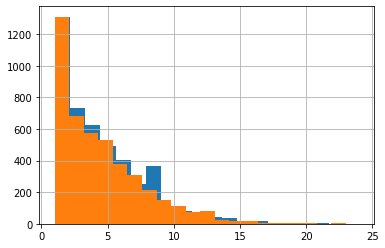

In [116]:
df1.loc[df1['group'] == 'GRP A','purchases'].hist(bins=20);
df1.loc[df1['group'] == 'GRP B','purchases'].hist(bins=20);

In [117]:
#distubuição normal
#list_mean =[]

#for i in range (1000):
    #m = df1.loc[df1['group'] == 'GRP A','purchases'].sample(90).mean()
    #list_mean.append(m)
#plt.hist(list_mean);

## 3.2 Escola de um país (ESPANHA)

In [95]:
df2 = df1.copy()

In [144]:
# TAMANHO DA AMOSTRA (ESPANHA)
init_metric = 1874.18
end_metric = init_metric * (1 + 0.10) #aumenta a porcentagem
std_metric = 1305.26

effect_size = (end_metric - init_metric)/std_metric


sample_size = sms.tt_ind_solve_power(
    effect_size=effect_size,
    alpha=0.05,
    power=0.80
)

sample_size = np.ceil(sample_size).astype(int)
print(sample_size)

763


In [145]:
df2 = df_raw.loc [df_raw['country'] =='ESP', :]
df2.head()

,uid,country,gender,spent,purchases,date,group,device
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A
17,11149952,ESP,M,398,2,2017-02-02,GRP A,A
40,11183968,ESP,M,996,4,2016-04-01,GRP A,A
45,11193748,ESP,M,299,1,2016-10-11,GRP A,A
47,11199766,ESP,F,199,1,2017-05-04,GRP A,A


In [146]:
df2['spent'].agg(['mean', 'std'])

mean    1874.184592
std     1305.259136
Name: spent, dtype: float64

In [147]:
print('Number of Rows:{}'.format(df2.shape[0]))
print('Number of Cols:{}'.format(df2.shape[1]))

Number of Rows:1934
Number of Cols:8


In [148]:
df2[['uid','group']].groupby('group').count().reset_index()
df2[['uid','group']].groupby('uid').count().reset_index().query('group>1')

,uid,group


### 3.2.1 Control and Treatment Homogenity

In [149]:
df2[['uid','group','gender']].groupby(['group', 'gender']).count().reset_index()

,group,gender,uid
0,GRP A,F,493
1,GRP A,M,477
2,GRP B,F,475
3,GRP B,M,489


In [150]:
df2[['uid','group','device']].groupby(['group', 'device']).count().reset_index()

,group,device,uid
0,GRP A,A,449
1,GRP A,I,521
2,GRP B,A,491
3,GRP B,I,473


In [151]:
df2.groupby('group').agg({'country':'count',
                          'spent':['min','max','median','std'],
                          'purchases':['min','max','median','std']
                         }).reset_index()

group country spent                            purchases             \
           count   min   max  median          std       min max median   
0  GRP A     970    99  8581  1497.0  1273.604015         1  19    4.0   
1  GRP B     964    99  8980  1696.0  1332.172125         1  20    4.0   

             
        std  
0  2.934934  
1  3.023540

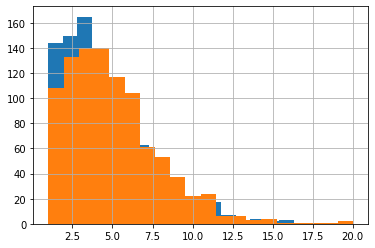

In [152]:
df2.loc[df2['group'] == 'GRP A','purchases'].hist(bins=20);
df2.loc[df2['group'] == 'GRP B','purchases'].hist(bins=20);

In [154]:
sample_A = df2.loc[df2['group'] == 'GRP A','spent'].sample(n=sample_size,random_state=42)
sample_B = df2.loc[df2['group'] == 'GRP B','spent'].sample(n=sample_size,random_state=42)

#Metrics
print('AVG Sample A: {} +/- {}'.format( np.round(sample_A.mean(), 2), np.round(sample_A.std(), 2)))
print('AVG Sample B: {} +/- {}'.format( np.round(sample_B.mean(), 2),np.round (sample_B.std(), 2)))

AVG Sample A: 1815.92 +/- 1271.61
AVG Sample B: 1950.69 +/- 1322.14


In [155]:
t_test,p_value =  stats.ttest_ind(sample_A, sample_B)
print('p-value {}'.format(p_value ))

p-value 0.04260378484423854


In [156]:
significance_level = 0.05
if p_value < significance_level:
    print('Reject Null Hypothesis') # O prenchimento automatico trouxe uma mudança significativa no GMV da 
                                    # da página (no brasil)
                                    # Colocar para a produção
else:
    print('Failed to Reject Null Hypothesis') # Não temos evidencia suficiencias para dizer que o preenchimento
                                             # automatico trouxe uma mudança no GMV da página(brasil)
                                            #Repensar a estrategia de dispositivo de prenchimento automatico

Reject Null Hypothesis


# 4.0 Test Hipóteses

## 4.1 Groups

In [132]:
sample_A = df1.loc[df1['group'] == 'GRP A','spent'].sample(n=sample_size,random_state=42)
sample_B = df1.loc[df1['group'] == 'GRP B','spent'].sample(n=sample_size,random_state=42)

#Metrics
print('AVG Sample A: {} +/- {}'.format( np.round(sample_A.mean(), 2), np.round(sample_A.std(), 2)))
print('AVG Sample B: {} +/- {}'.format( np.round(sample_B.mean(), 2),np.round (sample_B.std(), 2)))

AVG Sample A: 1908.56 +/- 1406.42
AVG Sample B: 1902.1 +/- 1383.93


## 4.2 Inferência Estatistica 

In [158]:
t_test,p_value =  stats.ttest_ind(sample_A, sample_B)
print('p-value {}'.format(p_value ))

p-value 0.04260378484423854


# 5.0 Conclusão 

In [157]:
significance_level = 0.05
if p_value < significance_level:
    print('Reject Null Hypothesis') # O prenchimento automatico trouxe uma mudança significativa no GMV da 
                                    # da página (no brasil)
                                    # Colocar para a produção
else:
    print('Failed to Reject Null Hypothesis') # Não temos evidencia suficiencias para dizer que o preenchimento
                                             # automatico trouxe uma mudança no GMV da página(brasil)
                                            #Repensar a estrategia de dispositivo de prenchimento automatico

Reject Null Hypothesis
